In [204]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import math

accum_x = 0.0
DECAY = 0.0
P = 0.0
I = 0.0
D = 0.0

def reset_pid(p: float, i: float, d: float, decay: float):
    global P, I, D, DECAY, accum_x
    accum_x = 0
    P = p
    I = i
    D = d
    DECAY = decay

def control(x: float, v: float, tx: float, tv: float, dt: float) -> float:
    global accum_x

    error = tx - x
    deriv_error = (tv - v) / dt

    accum_x += error * dt
    accum_x *= math.pow(abs(DECAY), dt)

    return P * error + I * accum_x + D * deriv_error


M = 1.0
def run_sim(path_def: tuple[float, npt.NDArray, npt.NDArray], x: float, v: float) -> tuple[npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray]:
    dt, ts, path = path_def

    vs = []
    xs = []
    txs = []
    tvs = []
    us = []

    # Simulation loop
    for t in range(path.shape[0]-1):
        tx = path[t]  # Get the desired position from the path function
        tv = (path[t+1]-path[t])/dt

        # Calculate control signal
        u = control(x, v, tx, tv, dt)

        # Update state variables using a simple integration scheme (Euler method)
        a = u / M
        v += a * dt
        x += v * dt
        xs.append(x)
        vs.append(v)
        txs.append(tx)
        tvs.append(tv)
        us.append(u)

    return (ts[1:], np.array(xs), np.array(vs), np.array(txs), np.array(tvs), np.array(us))

def plot_it(sim_out):
    t, x, v, tx, tv, u = sim_out
    plt.plot(t, x, "r")
    plt.plot(t, tx, "r--")
    # plt.plot(t, v, "b")
    # plt.plot(t, tv, "b--")
    # plt.plot(t, u, "m")
    plt.legend(["x", "tx", "v","tv", "control"])



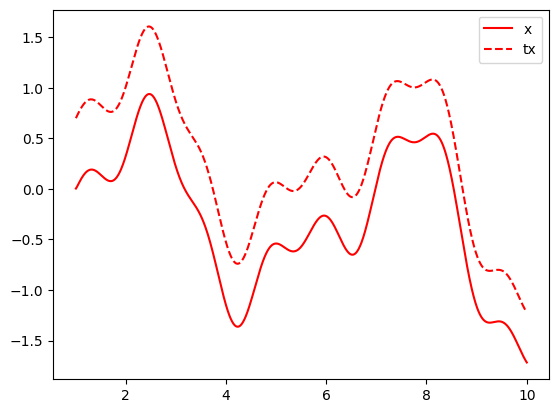

In [226]:

# Define a dummy function for the path
def gen_path(len: float, dt: float) -> tuple[float, npt.NDArray, npt.NDArray]:
    t = np.linspace(1,len, int(len/dt))
    
    x = np.sin(t) + np.sin(2.43*t+1.2)*0.4 + np.sin(5.3*t+7.5)*0.2 + np.sin(0.5*t-0.5)*0.7

    return (dt, t, x)

path = gen_path(10.0,0.01)

# Run the simulation
reset_pid(0.9, 0.6, 0.4, 0.3)

plot_it(run_sim(path, 0.0, 0.0))

Best PID parameters: (2.0, 2.0, 0.5222222222222223, 0.5444444444444445)


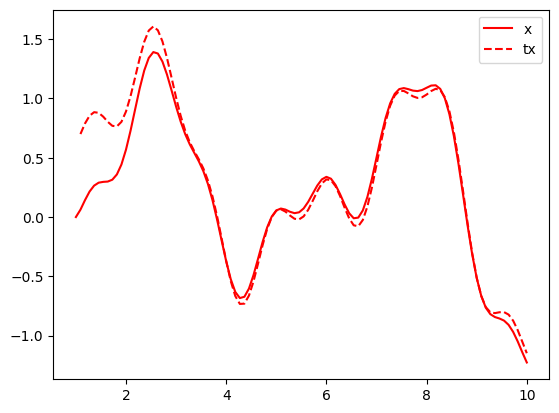

In [84]:
def optimize_pid(path_def: tuple[float, npt.NDArray, npt.NDArray], x: float, v: float):
    # Define ranges for PID parameters
    p_range = np.linspace(0.1, 2.0, 10)
    i_range = np.linspace(0.1, 2.0, 10)
    d_range = np.linspace(0.1, 2.0, 10)
    decay_range = np.linspace(0.1, 0.9, 10)

    best_error = float('inf')
    best_params = None

    for p_val in p_range:
        for i_val in i_range:
            for d_val in d_range:
                for decay_val in decay_range:
                    reset_pid(p_val, i_val, d_val, decay_val)
                    sim_out = run_sim(path_def, x, v)

                    # Calculate error (you might use a performance metric relevant to your system)
                    error = np.sum(np.abs(sim_out[1][1:] - sim_out[3]))  # Example: Absolute error between x and tx

                    # Update best parameters if error is improved
                    if error < best_error:
                        best_error = error
                        best_params = (p_val, i_val, d_val, decay_val)

    return best_params

# Using the optimize_pid function
best_params = optimize_pid(path, 0.0, 0.0)
print("Best PID parameters:", best_params)
reset_pid(*best_params)  # Set the best parameters to the PID controller
plot_it(run_sim(path, 0.0, 0.0))


Iteration 1, Error: 87.76086822522824
Iteration 2, Error: 87.7280966114485
Iteration 3, Error: 87.69817563523392
Iteration 4, Error: 87.6719275351236
Iteration 5, Error: 87.64829795811934
Iteration 6, Error: 87.62538159375337
Iteration 7, Error: 87.60192145723852
Iteration 8, Error: 87.57725172502329
Iteration 9, Error: 87.5508448832824
Iteration 10, Error: 87.52209523890205
Iteration 11, Error: 87.49019243875205
Iteration 12, Error: 87.4539735793975
Iteration 13, Error: 87.41167391924533
Iteration 14, Error: 87.36043982201745
Iteration 15, Error: 87.29526820265113
Iteration 16, Error: 87.20637054568422
Iteration 17, Error: 87.07580729086942
Iteration 18, Error: 86.89309792168152
Iteration 19, Error: 86.64456020084451
Iteration 20, Error: 86.29784849327814
Iteration 21, Error: 85.8240640004815
Iteration 22, Error: 85.12682537898088
Iteration 23, Error: 84.34753040394898
Iteration 24, Error: 82.54340871738196
Iteration 25, Error: 79.94866534924348
Iteration 26, Error: 77.3439235270941
I

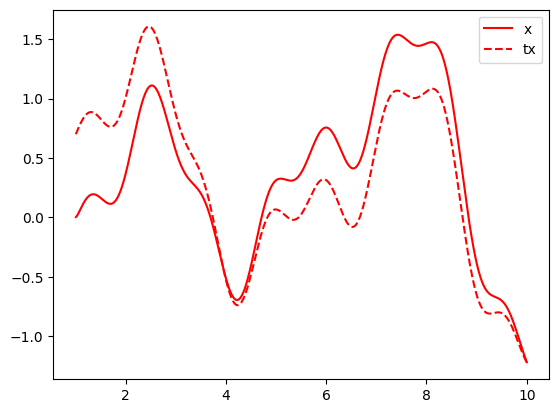

In [232]:
def calculate_error(path_def: tuple[float, npt.NDArray, npt.NDArray], x: float, v: float, params: tuple[float, float, float, float]) -> float:
    reset_pid(*params)
    sim_out = run_sim(path_def, x, v)
    L = sim_out[1].shape[0]
    t, x, v, tx, tv, u = sim_out 
    # E = sum{ abs(x - tx) } + sum{ u }
    error = np.sum(np.abs(x[L//3:] - tx[L//3:])*(t[1]-t[0])) + np.sum(u[L//3:])
    return error

def gradient_descent(path_def: tuple[float, npt.NDArray, npt.NDArray], x: float, v: float, initial_params: tuple[float, float, float, float], learning_rate: float, iterations: int) -> tuple[tuple[float, float, float, float], npt.NDArray]:
    current_params = np.array(initial_params)

    errors = []

    for _ in range(iterations):
        gradients = np.zeros(4)
        epsilon = 1e-1  # Small value for numerical stability

        # Calculate gradients numerically using finite differences
        for i in range(4):
            params_plus = current_params.copy()
            params_plus[i] += epsilon

            params_minus = current_params.copy()
            params_minus[i] -= epsilon

            error_plus = calculate_error(path_def, x, v, tuple(params_plus))
            error_minus = calculate_error(path_def, x, v, tuple(params_minus))

            gradients[i] = (error_plus - error_minus) / (2 * epsilon)

        # Update parameters using gradients
        current_params -= np.clip(learning_rate * gradients, -0.1, 0.1)

        # Clip parameters to reasonable values if needed
        current_params = np.clip(current_params, 0.05, 5.0)  # Assuming reasonable bounds for parameters
        current_params[-1] = np.clip(current_params[-1], 0.0, 0.9)  # Decay parameter

        # Print error for monitoring convergence (optional)
        error = calculate_error(path_def, x, v, tuple(current_params))
        errors.append(error)
        print(f"Iteration {_+1}, Error: {error}")

    return (tuple(current_params), np.array(errors))

import random

# Set initial PID parameters and hyperparameters
initial_params = (random.uniform(0.1,2.0), random.uniform(0.1,2.0), random.uniform(0.1,2.0), 0.3)
learning_rate = 0.2
iterations = 100

# Perform gradient descent for tuning PID parameters
best_params, errors = gradient_descent(path, 0.0, 0.0, initial_params, learning_rate, iterations)
print("Best PID parameters:", best_params)

# Reset PID with the best parameters found
reset_pid(*best_params)

# plt.plot(errors[5:])
plot_it(run_sim(path, 0.0, 0.0))
